In [7]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import optimize
from matplotlib.ticker import FormatStrFormatter

In [8]:
r = 10

galaxy_title = 'NGC 4631'
galaxy_file = galaxy_title.replace(' ', '_')

line_name = '[NIII]'

line_measurement = 0
addendum = ''

if line_name == '[OIII]':
    line_measurement = 52
    addendum = 'sw_1'
    
if line_name == '[NIII]':
    line_measurement = 57
    addendum = 'sw_2'

titlename = galaxy_title + ' ' + line_name + ' ' + str(line_measurement) + ' ' + r'$\mu$m, r = {}'.format(str(r))
filename = galaxy_file + '_' + line_name + '_r={}'.format(str(r))

In [9]:
loaddir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/' + galaxy_file + '_' + addendum + '/'

savedir = loaddir + 'r=' + str(r) + '/'

fits_name = galaxy_file + '_' + addendum + '.fits'
fits_spec_name = galaxy_file + '_' + addendum + '_r={}.fits'.format(str(r))

In [10]:
hdulist = fits.open(loaddir + fits_name)

hdulist.info()

Filename: /Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_4631_sw_2/NGC_4631_sw_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     311   ()      
  1  FLUX          1 ImageHDU        28   (53, 40, 47)   float64   
  2  ERROR         1 ImageHDU        28   (53, 40, 47)   float64   
  3  UNCORRECTED_FLUX    1 ImageHDU        28   (53, 40, 47)   float64   
  4  UNCORRECTED_ERROR    1 ImageHDU        28   (53, 40, 47)   float64   
  5  WAVELENGTH    1 ImageHDU         7   (47,)   float64   
  6  X             1 ImageHDU         7   (53,)   float64   
  7  Y             1 ImageHDU         7   (40,)   float64   
  8  TRANSMISSION    1 ImageHDU         7   (47,)   float64   
  9  RESPONSE      1 ImageHDU         7   (47,)   float32   
 10  EXPOSURE_MAP    1 ImageHDU        28   (53, 40, 47)   int16   
 11  UNSMOOTHED_TRANSMISSION    1 ImageHDU         8   (1341, 2)   float32   


In [11]:
hdulist[1].header

XTENSION= 'IMAGE   '           /extension type                                  
BITPIX  =                  -64 /bits per data value                             
NAXIS   =                    3 /number of axes                                  
NAXIS1  =                   53 /                                                
NAXIS2  =                   40 /                                                
NAXIS3  =                   47 /                                                
PCOUNT  =                    0 /                                                
GCOUNT  =                    1 /                                                
EXTNAME = 'FLUX    '           /                                                
DATE-OBS= '2019-05-10T09:06:35' / Observation date                              
BUNIT   = 'Jy/pixel'           / Data units                                     
EQUINOX =              2000.00 / Coordinate equinox                             
CTYPE1  = 'RA---TAN'        

In [12]:
hdulist_spec = fits.open(savedir + fits_spec_name)
hdulist_spec.info()

Filename: /Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_4631_sw_2/r=10/NGC_4631_sw_2_r=10.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  FLUX          1 PrimaryHDU      28   (47,)   float32   


In [13]:
wavelengths = hdulist[5].data

print(wavelengths)

wav_diff = []

for i in range(0, len(wavelengths)-1):
    wav_diff.append(wavelengths[i+1]-wavelengths[i])
  
wav_diff = np.average(wav_diff)

print(wav_diff)

[57.25034319 57.25832029 57.2662974  57.2742745  57.28225161 57.29022871
 57.29820581 57.30618292 57.31416002 57.32213713 57.33011423 57.33809134
 57.34606844 57.35404554 57.36202265 57.36999975 57.37797686 57.38595396
 57.39393106 57.40190817 57.40988527 57.41786238 57.42583948 57.43381658
 57.44179369 57.44977079 57.4577479  57.465725   57.4737021  57.48167921
 57.48965631 57.49763342 57.50561052 57.51358762 57.52156473 57.52954183
 57.53751894 57.54549604 57.55347315 57.56145025 57.56942735 57.57740446
 57.58538156 57.59335867 57.60133577 57.60931287 57.61728998]
0.0079771040646393


In [14]:
central_fluxes_unfiltered = hdulist_spec[0].data
    
central_fluxes_unfiltered = [flux*(10**(-26)) for flux in central_fluxes_unfiltered]

c = 3*10**8

for i in range(0, len(wavelengths)):
    
    wavelength = wavelengths[i]
    
    central_fluxes_unfiltered[i] = central_fluxes_unfiltered[i]*(c/(wavelength*10**(-6))**2)*(10**(-6))
    
central_fluxes_unfiltered = np.array(central_fluxes_unfiltered)

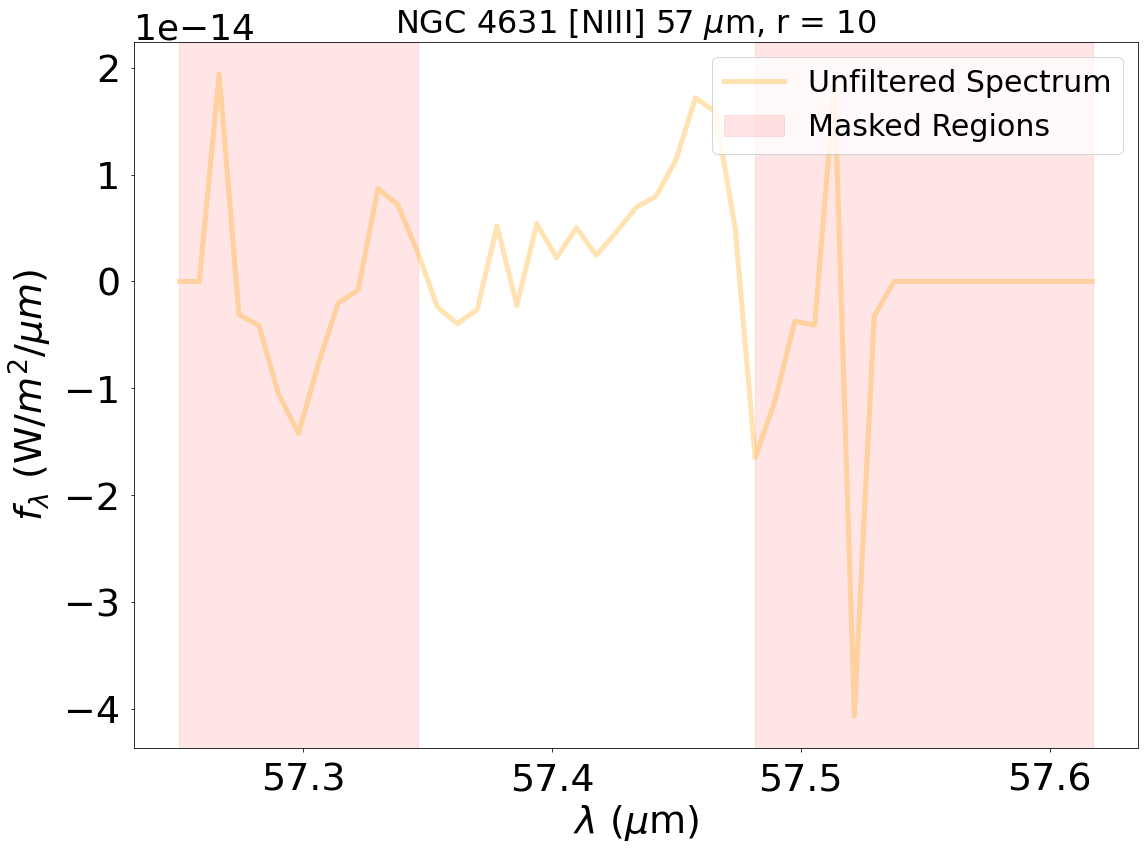

In [20]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.axvspan(wavelengths[0], wavelengths[12], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax.axvspan(wavelengths[-18], wavelengths[-1], color = 'red', alpha = 0.1)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

plt.savefig(savedir + filename + '-1-unfiltered_spectrum.png'.format(str(r)))

ax.legend(prop={'size': 30}, loc = 'upper right')

In [21]:
print(central_fluxes_unfiltered)

[ 0.00000000e+00  0.00000000e+00  1.94476173e-14 -3.12375429e-15
 -4.10941370e-15 -1.05960812e-14 -1.42389356e-14 -7.68653608e-15
 -2.00299537e-15 -8.22332946e-16  8.70984118e-15  7.17265990e-15
  2.72932039e-15 -2.40009192e-15 -3.95548529e-15 -2.63423841e-15
  5.19338583e-15 -2.25920365e-15  5.41412910e-15  2.21378962e-15
  5.02747628e-15  2.44827618e-15  4.59959653e-15  6.91988507e-15
  7.96262613e-15  1.13335607e-14  1.72048555e-14  1.58502985e-14
  4.95150833e-15 -1.65126071e-14 -1.11930671e-14 -3.73994630e-15
 -4.08731964e-15  1.84306650e-14 -4.07122236e-14 -3.23999476e-15
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [22]:
central_fluxes_filtered = central_fluxes_unfiltered
central_fluxes_filtered = central_fluxes_filtered[12:-17]

wavelengths_filtered = wavelengths[12:-17]

print(central_fluxes_filtered)

[ 2.72932039e-15 -2.40009192e-15 -3.95548529e-15 -2.63423841e-15
  5.19338583e-15 -2.25920365e-15  5.41412910e-15  2.21378962e-15
  5.02747628e-15  2.44827618e-15  4.59959653e-15  6.91988507e-15
  7.96262613e-15  1.13335607e-14  1.72048555e-14  1.58502985e-14
  4.95150833e-15 -1.65126071e-14]


In [29]:
central_fluxes_filtered_continuum = []

left_cut = 57.415
right_cut = 57.475

for i in range(0, len(wavelengths_filtered)):
    
    wavelength = wavelengths_filtered[i]
    
    if(wavelength < left_cut or wavelength > right_cut):
        central_fluxes_filtered_continuum.append(central_fluxes_filtered[i])
    
    else:
        central_fluxes_filtered_continuum.append(float("Nan"))
        
central_fluxes_filtered_continuum = np.array(central_fluxes_filtered_continuum)

print(central_fluxes_filtered_continuum)

[ 2.72932039e-15 -2.40009192e-15 -3.95548529e-15 -2.63423841e-15
  5.19338583e-15 -2.25920365e-15  5.41412910e-15  2.21378962e-15
  5.02747628e-15             nan             nan             nan
             nan             nan             nan             nan
             nan -1.65126071e-14]


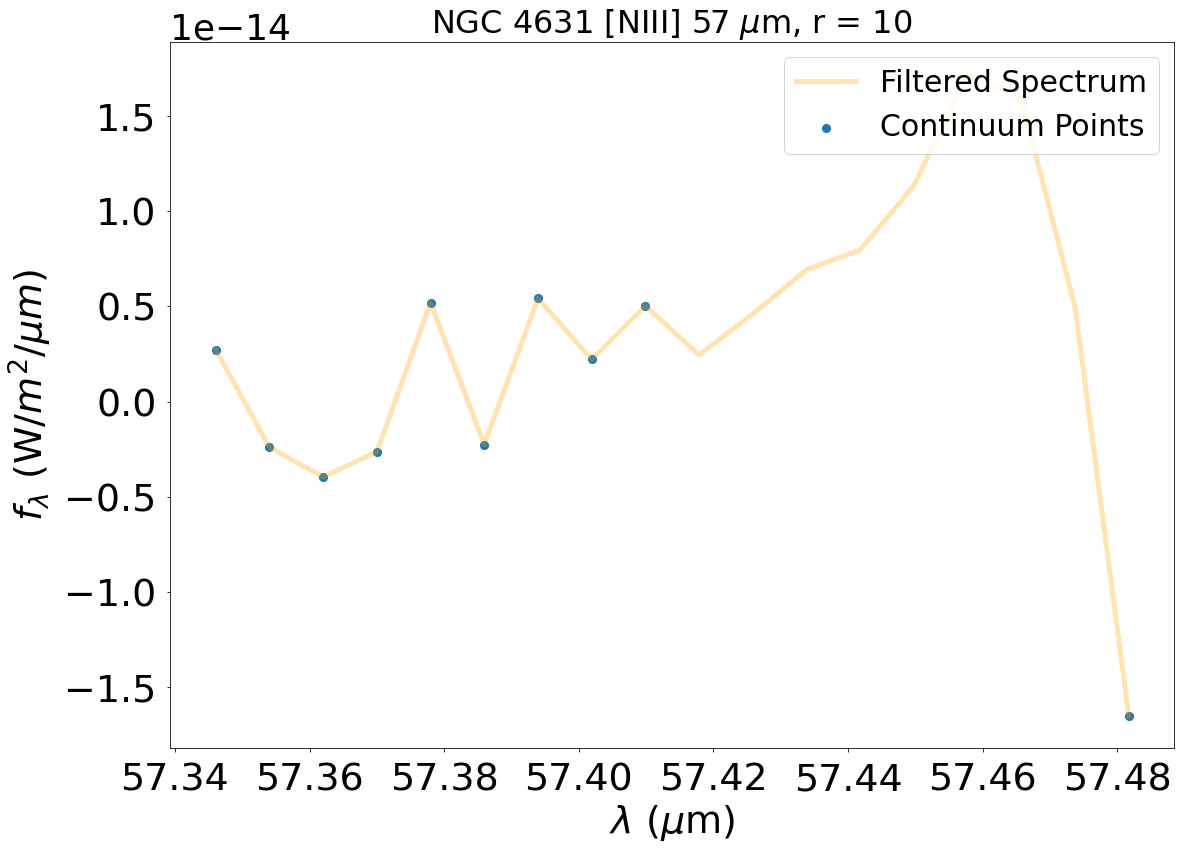

In [30]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Filtered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + filename + '-2-filtered_spectrum + continuum_points.png'.format(str(r)))

In [31]:
idcont = np.isfinite(central_fluxes_filtered_continuum)
cont_params = np.polyfit(wavelengths_filtered[idcont], central_fluxes_filtered_continuum[idcont], 1)

print(cont_params)

cont_line_filtered = cont_params[0]*wavelengths_filtered + cont_params[1]

[-9.64433807e-14  5.53400785e-12]


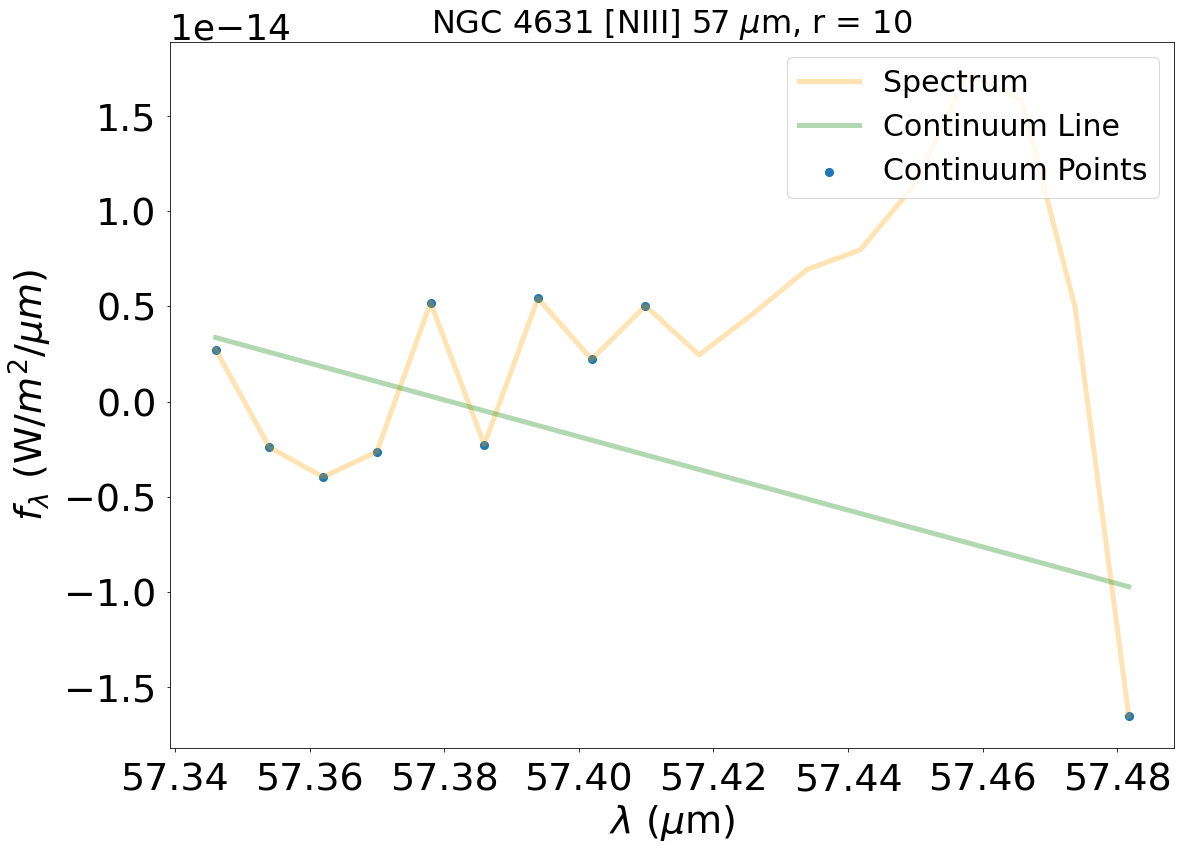

In [32]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelengths_filtered, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + filename + '-3-filtered_spectrum + continuum_line.png'.format(str(r)))

In [33]:
id_act = np.isnan(central_fluxes_filtered_continuum)

wavelengths_act = wavelengths_filtered[id_act]
central_fluxes_filtered_act = central_fluxes_filtered[id_act]
cont_line_filtered_act = cont_line_filtered[id_act]

central_fluxes_continuum_subtracted_act = central_fluxes_filtered_act - cont_line_filtered_act

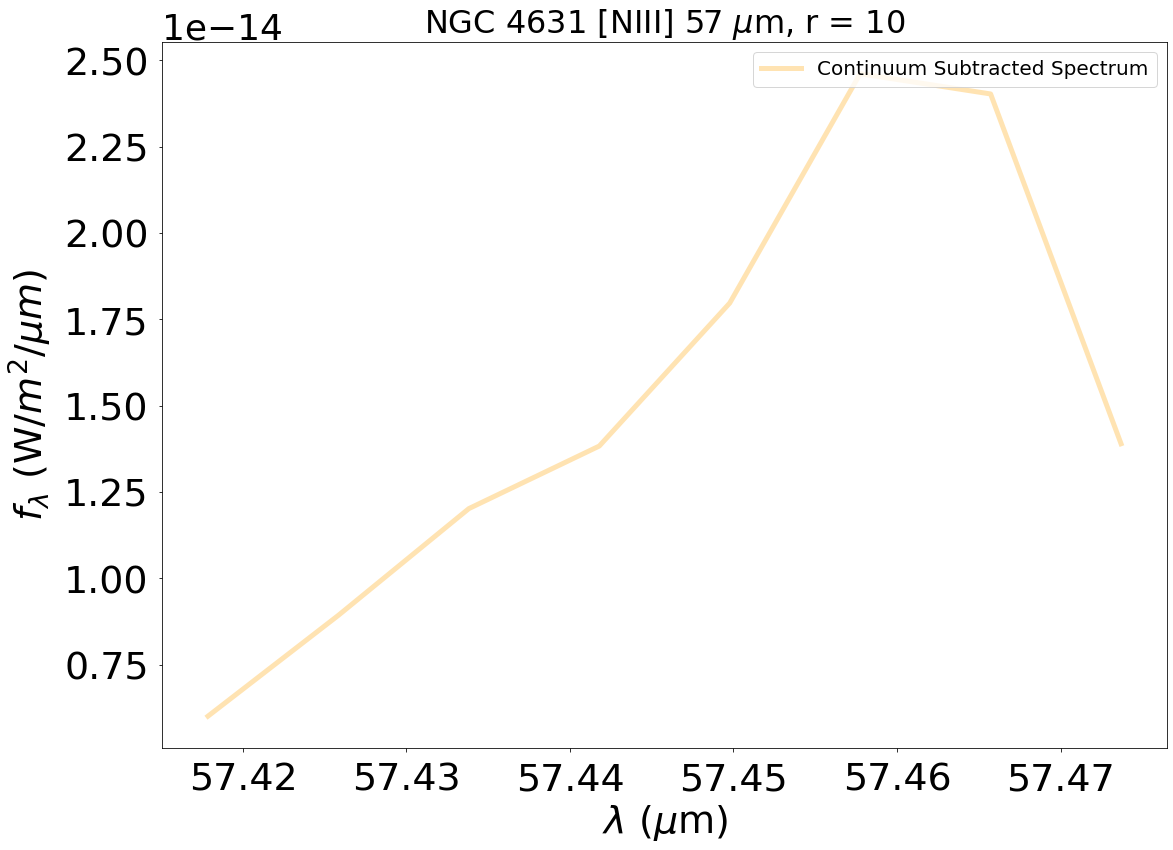

In [34]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, label = 'Continuum Subtracted Spectrum', lw = 5, color = 'orange', alpha = 0.3)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + filename + '-4-continuum_subtracted_spectrum.png'.format(str(r)))

In [35]:
def fit_func_1(Z, peak_height, mu, sigma):
    
    P = peak_height*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

In [36]:
heights = central_fluxes_continuum_subtracted_act/np.max(central_fluxes_continuum_subtracted_act)

centers = wavelengths_act

# Information about the peak in the numerical PDF
peak_ind = np.where(heights == np.max(heights))[0][0]
peak_height = np.max(heights)

# mu is where the numerical PDF peaks
mu = centers[peak_ind]

# Estimating sigma using FWHM
sigma = 0

for i in range(0, peak_ind):
    if(heights[i] >= peak_height/2):
        sigma = (mu - centers[i])/np.sqrt(2*np.log(2))
        break

# First fit a Gaussian

guess_params = np.array([peak_height, sigma])
fit_params, fit_covar = optimize.curve_fit(lambda centers, peak_height, sigma: 
                                           fit_func_1(centers, peak_height, mu, sigma), 
                                           centers, heights, p0=guess_params)

fit_params = [fit_params[0], mu, fit_params[1]]

fit_params[0] *= np.max(central_fluxes_continuum_subtracted_act)

print(fit_params)

[2.1939313301059755e-14, 57.45774789629009, 0.02178195453941063]


[4.10320145e-15 4.45835514e-15 4.83404984e-15 5.23036780e-15
 5.64726255e-15 6.08454869e-15 6.54189253e-15 7.01880348e-15
 7.51462656e-15 8.02853613e-15 8.55953105e-15 9.10643140e-15
 9.66787690e-15 1.02423272e-14 1.08280642e-14 1.14231964e-14
 1.20256651e-14 1.26332535e-14 1.32435970e-14 1.38541967e-14
 1.44624337e-14 1.50655870e-14 1.56608517e-14 1.62453600e-14
 1.68162031e-14 1.73704548e-14 1.79051960e-14 1.84175396e-14
 1.89046564e-14 1.93638008e-14 1.97923366e-14 2.01877618e-14
 2.05477332e-14 2.08700893e-14 2.11528720e-14 2.13943460e-14
 2.15930173e-14 2.17476479e-14 2.18572690e-14 2.19211908e-14
 2.19390103e-14 2.19106148e-14 2.18361836e-14 2.17161861e-14
 2.15513765e-14 2.13427864e-14 2.10917135e-14 2.07997086e-14
 2.04685596e-14 2.01002730e-14 1.96970539e-14 1.92612839e-14
 1.87954979e-14 1.83023594e-14 1.77846354e-14 1.72451707e-14]


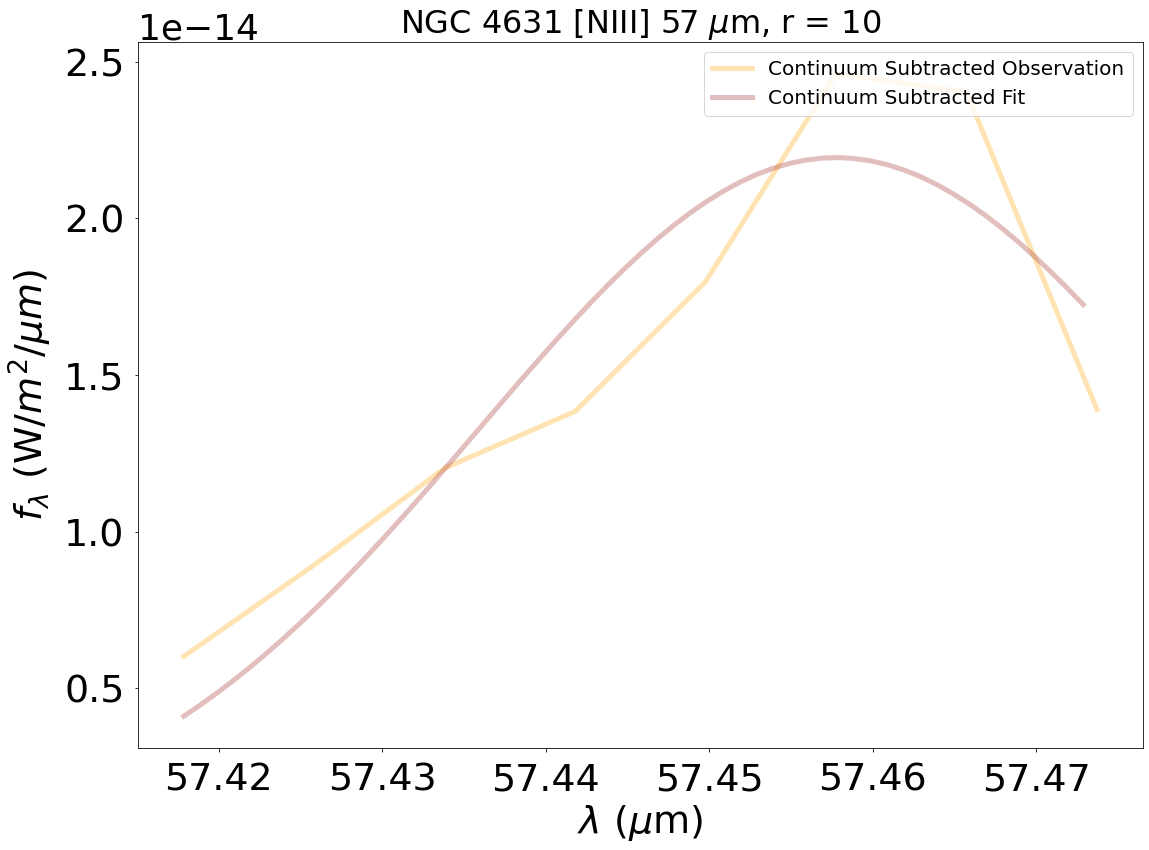

In [37]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_act), np.max(wavelengths_act), 0.001)

fitted_central_fluxes_continuum_subtracted_act = fit_func_1(wavelength_range, *fit_params)

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Observation', lw = 5, color = 'orange', alpha = 0.3)

ax.plot(wavelength_range, fitted_central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Fit', lw = 5, color = 'brown', alpha = 0.3)


ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + filename + '-5-fit_continuum_subtracted_spectrum.png'.format(str(r)))

[4.10320145e-15 4.45835514e-15 4.83404984e-15 5.23036780e-15
 5.64726255e-15 6.08454869e-15 6.54189253e-15 7.01880348e-15
 7.51462656e-15 8.02853613e-15 8.55953105e-15 9.10643140e-15
 9.66787690e-15 1.02423272e-14 1.08280642e-14 1.14231964e-14
 1.20256651e-14 1.26332535e-14 1.32435970e-14 1.38541967e-14
 1.44624337e-14 1.50655870e-14 1.56608517e-14 1.62453600e-14
 1.68162031e-14 1.73704548e-14 1.79051960e-14 1.84175396e-14
 1.89046564e-14 1.93638008e-14 1.97923366e-14 2.01877618e-14
 2.05477332e-14 2.08700893e-14 2.11528720e-14 2.13943460e-14
 2.15930173e-14 2.17476479e-14 2.18572690e-14 2.19211908e-14
 2.19390103e-14 2.19106148e-14 2.18361836e-14 2.17161861e-14
 2.15513765e-14 2.13427864e-14 2.10917135e-14 2.07997086e-14
 2.04685596e-14 2.01002730e-14 1.96970539e-14 1.92612839e-14
 1.87954979e-14 1.83023594e-14 1.77846354e-14 1.72451707e-14]


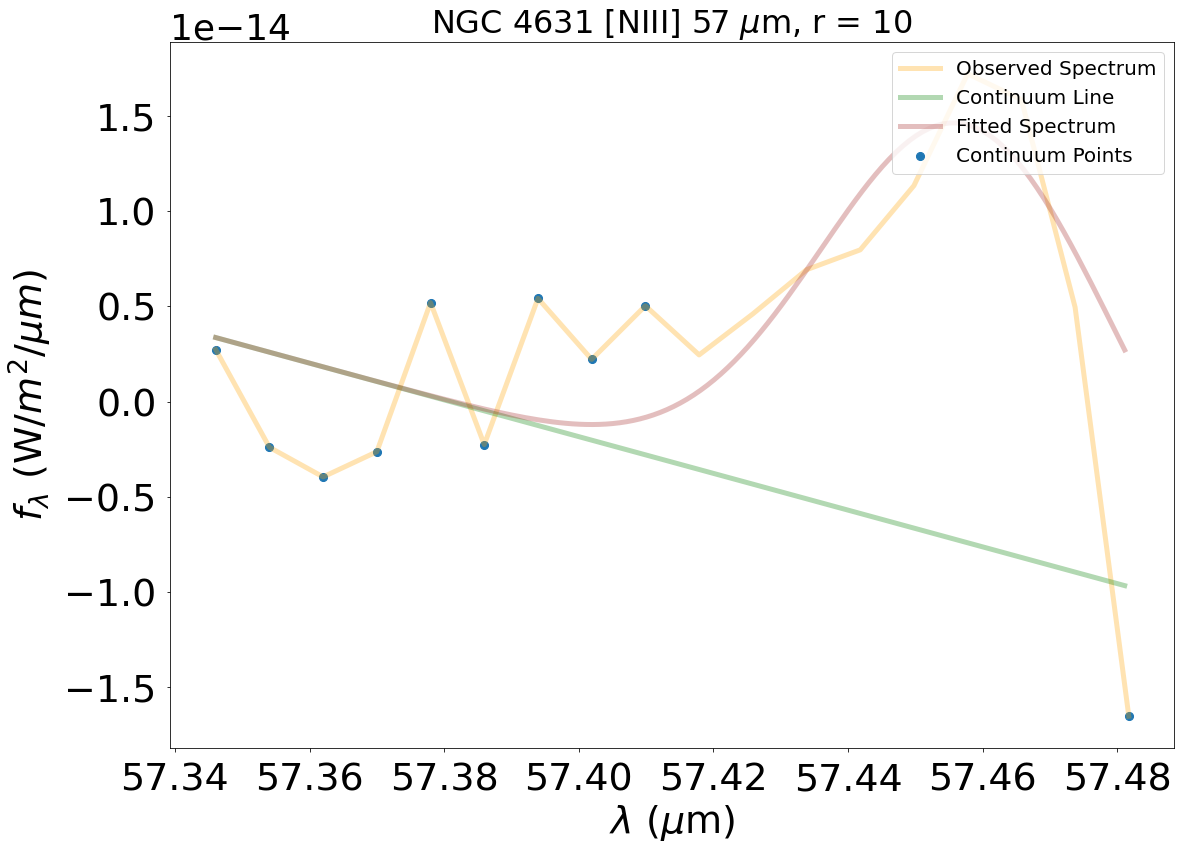

In [38]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_filtered), np.max(wavelengths_filtered), 0.001)
cont_line_filtered = cont_params[0]*wavelength_range + cont_params[1]

fitted_central_fluxes_act = fit_func_1(wavelength_range, *fit_params) + cont_line_filtered

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(titlename, fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + filename + '-6-final_spectrum.png'.format(str(r)))

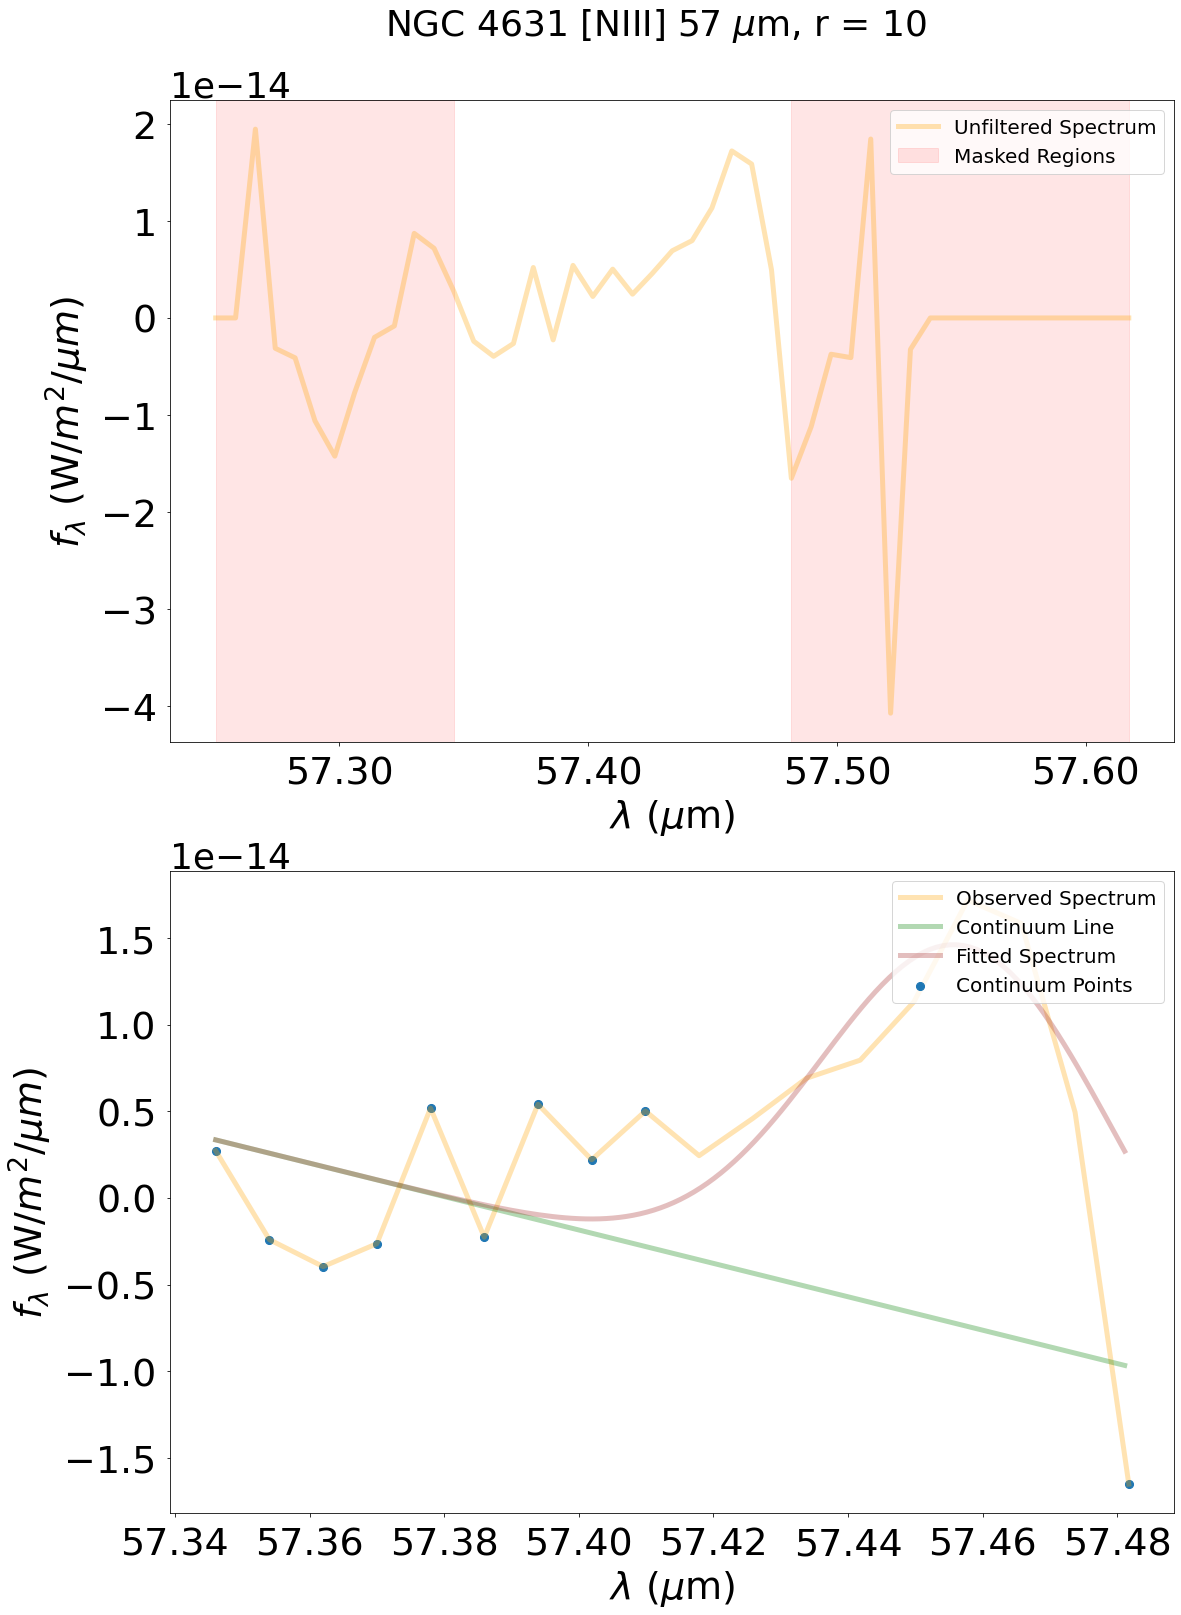

In [41]:
fig, axs = plt.subplots(2, 1, figsize = (18, 26))

ax1 = axs[0]

ax1.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax1.axvspan(wavelengths[0], wavelengths[12], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax1.axvspan(wavelengths[-18], wavelengths[-1], color = 'red', alpha = 0.1)

ax1.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax1.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.tick_params(labelsize = 38, pad = 10)
ax1.yaxis.offsetText.set_fontsize(36)
ax1.legend(prop={'size': 20}, loc = 'upper right')

ax2 = axs[1]

ax2.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax2.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax2.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax2.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax2.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax2.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax2.tick_params(labelsize = 38, pad = 10)
ax2.yaxis.offsetText.set_fontsize(36)
ax2.legend(prop={'size': 20}, loc = 'upper right')

fig.suptitle(titlename, fontsize = 36, y = 0.93)

plt.savefig(savedir + filename + '-7-summary_spectrum.png'.format(str(r)))

In [42]:
flux_continuum = np.trapz(cont_line_filtered, x = wavelength_range, dx = wav_diff)

flux_obs = np.trapz(central_fluxes_filtered, x = wavelengths_filtered, dx = wav_diff)
flux_obs_sub = flux_obs - flux_continuum

flux_fit = np.trapz(fitted_central_fluxes_act, x = wavelength_range, dx = wav_diff)
flux_fit_sub = flux_fit - flux_continuum

In [43]:
f = open(savedir + filename + "_measurements.txt".format(str(r)), "w")
f.write('Flux of the continuum = ' + str(flux_continuum) + ' W/m^2 \n')
f.write('Flux of the continuum subtracted observation = ' + str(flux_obs_sub) + ' W/m^2 \n')
f.write('Flux of the continuum subtracted fit = ' + str(flux_fit_sub) + ' W/m^2 \n')
f.write('FWHM of fitted Gaussian = ' + str(str(2*np.sqrt(np.log(2))*fit_params[2])) + r' microns')
f.close()